<a href="https://colab.research.google.com/github/Ehsan-Roohi/Cavity/blob/main/Relaxation_DSMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TensorFlow Version: 2.18.0
Numba Version: 0.60.0

--- Running DSMC for T = 200.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
    ... T=200.0K, Step 20000/80000 completed ...
    ... T=200.0K, Step 40000/80000 completed ...
    ... T=200.0K, Step 60000/80000 completed ...
    ... T=200.0K, Step 80000/80000 completed ...
DSMC for T = 200.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 275.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
    ... T=275.0K, Step 20000/80000 completed ...
    ... T=275.0K, Step 40000/80000 completed ...
    ... T=275.0K, Step 60000/80000 completed ...
    ... T=275.0K, Step 80000/80000 completed ...
DSMC for T = 275.0 K finished. Collected 400010000 samples.

--- Running DSMC for T = 350.0 K with 'High Quality' settings ---
Starting simulation for 80000 steps...
    ... T=350.0K, Step 20000/80000 completed ...
    ... T=350.0K, Step 40000/80000 completed ...
    ... T=350.0K, Step 

Model: "Final_DNN_GPU"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 512)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 494,337 (1.89 MB)

 Trainable params: 494,337 (1.89 MB)

 Non-trainable params: 0 (0.00 B)


Created tf.data pipelines with batch size 1024.

Starting final model training (GPU Optimized)...
Epoch 1/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 20s/step - loss: 0.3044 - val_loss: 0.1492
Epoch 2/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.1563 - val_loss: 0.0840
Epoch 3/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0774 - val_loss: 0.0868
Epoch 4/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0726 - val_loss: 0.0866
Epoch 5/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0704 - val_loss: 0.0751
Epoch 6/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - loss: 0.0601 - val_loss: 0.0564
Epoch 7/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0454 - val_loss: 0.0406
Epoch 8/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0355 - val_loss: 0.0349
Epoch 9/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.0333 - val_loss: 0.0322
Epoch 10/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.0320 - val_loss: 0.0284
Epoch 11/500
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0

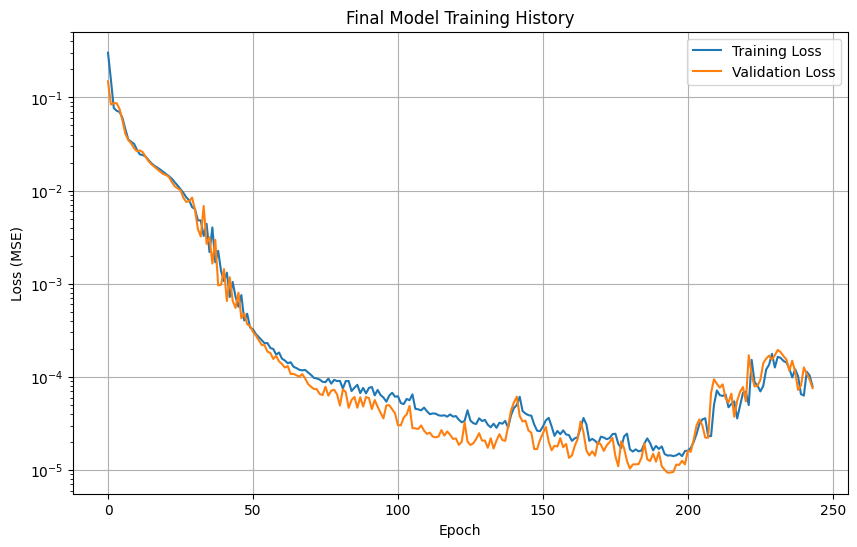


--- Final Model Prediction for an UNSEEN temperature (325 K) ---


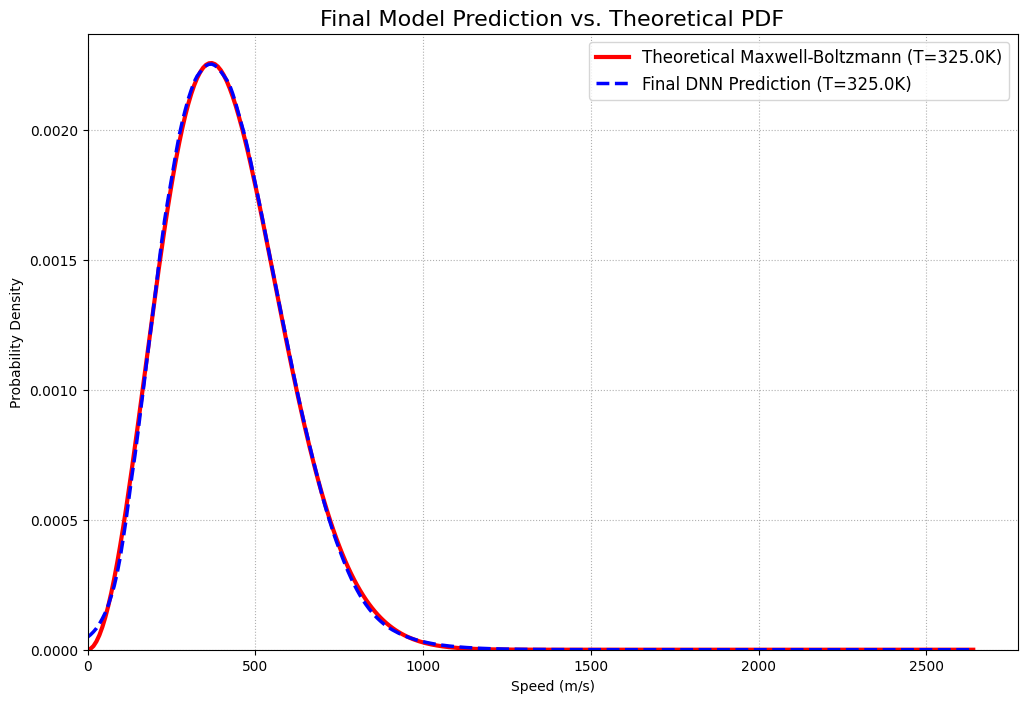


--- Final Model Prediction for a SEEN temperature (500 K) ---


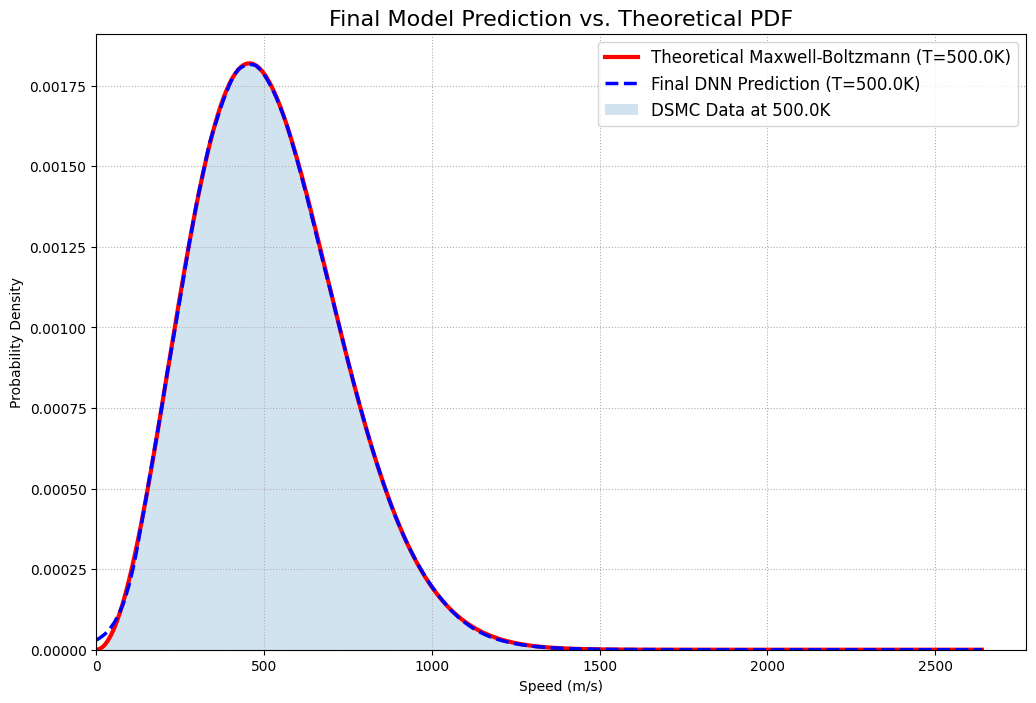

In [1]:
# ======================================================================
# FINAL ROBUST IMPLEMENTATION: Standard Supervised Deep Neural Network
# This version is optimized for GPU execution using a tf.data pipeline.
# ======================================================================

# --- Step 1: Imports and Setup ---
import numpy as np
import matplotlib.pyplot as plt
import numba
import time
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print("TensorFlow Version:", tf.__version__)
print("Numba Version:", numba.__version__)

# --- Step 2: DSMC Data Generation Function ---
# (Using the original, proven DSMC code)

# Constants
MOLAR_MASS_AR = 39.948e-3; AVOGADRO_NUM = 6.022e23; MASS_AR = MOLAR_MASS_AR / AVOGADRO_NUM; KB = 1.380649e-23; D_REF_AR = 4.17e-10; T_REF_AR = 273.0; OMEGA_VHS = 0.81

@numba.jit(nopython=True)
def calculate_vhs_cross_section_numba(vr_mag):
    if vr_mag < 1e-9: return 1e-30
    exponent = OMEGA_VHS - 0.5; c_ref_sq = 2 * KB * T_REF_AR / MASS_AR; gamma_val = 1.04533
    d_sq = (D_REF_AR**2) * ((c_ref_sq / vr_mag**2)**exponent) * (1 / gamma_val)
    return np.pi * d_sq

@numba.jit(nopython=True)
def perform_collisions_in_cell_numba(particles, indices_in_cell, cell_vol, dt, fnum, sigma_vr_max):
    num_particles_in_cell = len(indices_in_cell)
    if num_particles_in_cell < 2: return
    num_candidate_pairs = (num_particles_in_cell * (num_particles_in_cell - 1) * fnum * sigma_vr_max * dt) / (2.0 * cell_vol)
    num_pairs_to_select = int(np.floor(num_candidate_pairs + np.random.rand()))
    for _ in range(num_pairs_to_select):
        idx1_local = np.random.randint(0, num_particles_in_cell)
        idx2_local = np.random.randint(0, num_particles_in_cell)
        while idx1_local == idx2_local: idx2_local = np.random.randint(0, num_particles_in_cell)
        p1_idx, p2_idx = indices_in_cell[idx1_local], indices_in_cell[idx2_local]
        vrx, vry, vrz = particles[p1_idx, 1] - particles[p2_idx, 1], particles[p1_idx, 2] - particles[p2_idx, 2], particles[p1_idx, 3] - particles[p2_idx, 3]
        vr_mag = np.sqrt(vrx**2 + vry**2 + vrz**2)
        if vr_mag < 1e-9: continue
        sigma_t = calculate_vhs_cross_section_numba(vr_mag)
        if np.random.rand() < (sigma_t * vr_mag) / sigma_vr_max:
            vcm_x, vcm_y, vcm_z = 0.5 * (particles[p1_idx, 1] + particles[p2_idx, 1]), 0.5 * (particles[p1_idx, 2] + particles[p2_idx, 2]), 0.5 * (particles[p1_idx, 3] + particles[p2_idx, 3])
            cos_chi = 2 * np.random.rand() - 1.0; sin_chi = np.sqrt(1.0 - cos_chi**2); phi_chi = 2.0 * np.pi * np.random.rand()
            vr_prime_x, vr_prime_y, vr_prime_z = vr_mag * sin_chi * np.cos(phi_chi), vr_mag * sin_chi * np.sin(phi_chi), vr_mag * cos_chi
            particles[p1_idx, 1:4] = vcm_x + 0.5 * vr_prime_x, vcm_y + 0.5 * vr_prime_y, vcm_z + 0.5 * vr_prime_z
            particles[p2_idx, 1:4] = vcm_x - 0.5 * vr_prime_x, vcm_y - 0.5 * vr_prime_y, vcm_z - 0.5 * vr_prime_z

def run_dsmc_simulation(target_temp, params):
    print(f"\n--- Running DSMC for T = {target_temp} K with '{params['name']}' settings ---")
    NUM_CELLS_X = params['num_cells']; PARTICLES_PER_CELL_INIT = params['particles_per_cell']; TOTAL_TIME = params['total_time']; SAMPLING_START_TIME = params['sampling_start']
    TOTAL_PARTICLES_SIM = NUM_CELLS_X * PARTICLES_PER_CELL_INIT; LX=1.0e-6; RHO_INIT=1.78
    N_DENSITY_REAL = RHO_INIT / MASS_AR; CELL_VOLUME_CONCEPTUAL = (LX**3) / NUM_CELLS_X
    FNUM = (N_DENSITY_REAL * CELL_VOLUME_CONCEPTUAL) / PARTICLES_PER_CELL_INIT
    DT=1.0e-11; NUM_STEPS=int(TOTAL_TIME/DT); SAMPLING_START_STEP=int(SAMPLING_START_TIME/DT)
    particles = np.zeros((TOTAL_PARTICLES_SIM, 4)); cell_width = LX / NUM_CELLS_X
    for i in range(NUM_CELLS_X):
        start_idx, end_idx = i * PARTICLES_PER_CELL_INIT, (i + 1) * PARTICLES_PER_CELL_INIT
        particles[start_idx:end_idx, 0] = i * cell_width + np.random.rand(PARTICLES_PER_CELL_INIT) * cell_width
    particles[:, 1:4] = 800.0 * (2.0 * np.random.rand(TOTAL_PARTICLES_SIM, 3) - 1.0)
    current_total_ke = 0.5 * MASS_AR * np.sum(particles[:, 1:4]**2); target_total_ke = 1.5 * TOTAL_PARTICLES_SIM * KB * target_temp
    scaling_factor = np.sqrt(target_total_ke / current_total_ke); particles[:, 1:4] *= scaling_factor
    vr_max_estimate = 10.0 * np.sqrt(KB * target_temp / MASS_AR); SIGMA_VR_MAX_GLOBAL = calculate_vhs_cross_section_numba(vr_max_estimate) * vr_max_estimate
    sampled_speeds_accumulator = []
    print(f"Starting simulation for {NUM_STEPS} steps...")
    for step in range(1, NUM_STEPS + 1):
        particles[:, 0] = (particles[:, 0] + particles[:, 1] * DT) % LX
        cell_indices = (particles[:, 0] / cell_width).astype(np.int64); sorted_particle_indices = np.argsort(cell_indices)
        cell_counts = np.bincount(cell_indices, minlength=NUM_CELLS_X); cell_start_indices = np.concatenate(([0], np.cumsum(cell_counts[:-1])))
        for i in range(NUM_CELLS_X):
            start, end = cell_start_indices[i], cell_start_indices[i] + cell_counts[i]
            perform_collisions_in_cell_numba(particles, sorted_particle_indices[start:end], CELL_VOLUME_CONCEPTUAL, DT, FNUM, SIGMA_VR_MAX_GLOBAL)
        if step >= SAMPLING_START_STEP: sampled_speeds_accumulator.extend(np.sqrt(np.sum(particles[:, 1:4]**2, axis=1)))
        if step % (NUM_STEPS // 4) == 0: print(f"    ... T={target_temp}K, Step {step}/{NUM_STEPS} completed ...")
    print(f"DSMC for T = {target_temp} K finished. Collected {len(sampled_speeds_accumulator)} samples.")
    return np.array(sampled_speeds_accumulator)

# --- Step 3: High-Quality Data Generation and Preprocessing ---
simulation_params = {
    "name": "High Quality",
    "num_cells": 20,
    "particles_per_cell": 500,
    "total_time": 8.0e-7,
    "sampling_start": 4.0e-7,
}
training_temperatures = [200.0, 275.0, 350.0, 425.0, 500.0, 575.0, 650.0]
dsmc_results = {}
for temp in training_temperatures:
    dsmc_results[temp] = run_dsmc_simulation(target_temp=temp, params=simulation_params)

NUM_BINS = 200
X_train_list, y_train_list = [], []
for temp, speeds in dsmc_results.items():
    hist, bin_edges = np.histogram(speeds, bins=NUM_BINS, density=True)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2.0
    for i in range(len(bin_centers)):
        X_train_list.append([bin_centers[i], temp])
        y_train_list.append(hist[i])
print("\nInjecting physical boundary condition (v=0, P=0)...")
for temp in training_temperatures:
    X_train_list.append([0.0, temp])
    y_train_list.append(0.0)
X_train, y_train = np.array(X_train_list), np.array(y_train_list)
x_mean, x_std = np.mean(X_train, axis=0), np.std(X_train, axis=0)
X_train_normalized = (X_train - x_mean) / x_std
y_max = np.max(y_train)
y_train_normalized = y_train / y_max
print(f"\nCreated a high-quality training dataset with {len(X_train)} samples.")


# --- Step 4: Define and Train the Final, Stable DNN Model (GPU OPTIMIZED) ---

# --- GPU Optimization 1: Deeper Model Architecture ---
# A slightly deeper model can better leverage the parallel processing power of a GPU.
model = keras.Sequential([
    layers.Input(shape=(2,)),
    layers.Dense(512, activation='relu'),
    layers.Dense(512, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(256, activation='relu'),
    layers.Dense(128, activation='relu'), # Added layer
    layers.Dense(1, activation='softplus')
], name="Final_DNN_GPU")
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001), loss='mean_squared_error')
model.summary()

# --- GPU Optimization 2: Use tf.data.Dataset for Efficient Data Input ---
# This creates a highly efficient data pipeline that feeds the GPU without bottlenecks.
BATCH_SIZE = 1024 # Larger batch sizes are often more efficient on GPUs
SHUFFLE_BUFFER = 10000

# Create training and validation datasets
from sklearn.model_selection import train_test_split
X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
    X_train_normalized, y_train_normalized, test_size=0.2, random_state=42
)

train_dataset = tf.data.Dataset.from_tensor_slices((X_train_np, y_train_np))
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((X_val_np, y_val_np))
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print(f"\nCreated tf.data pipelines with batch size {BATCH_SIZE}.")

print("\nStarting final model training (GPU Optimized)...")
history = model.fit(
    train_dataset, # Train on the efficient dataset
    epochs=500,
    validation_data=val_dataset, # Validate on the efficient dataset
    verbose=1,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50, restore_best_weights=True)
    ]
)
print("Training finished.")
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Final Model Training History'), plt.xlabel('Epoch'), plt.ylabel('Loss (MSE)')
plt.yscale('log'), plt.legend(), plt.grid(True), plt.show()


# --- Step 5: Evaluate the Final Model ---
def plot_final_prediction(test_temp):
    max_speed_in_data = np.max([np.max(s) for s in dsmc_results.values()])
    v_test = np.linspace(0, max_speed_in_data * 1.1, 300)
    nn_input = np.stack([v_test, np.full_like(v_test, test_temp)], axis=-1)
    nn_input_normalized = (nn_input - x_mean) / x_std
    predicted_pdf_normalized = model.predict(nn_input_normalized, verbose=0)
    predicted_pdf = predicted_pdf_normalized * y_max
    theoretical_pdf = (4*np.pi*(MASS_AR/(2*np.pi*KB*test_temp))**1.5 * v_test**2 * np.exp(-MASS_AR*v_test**2/(2*KB*test_temp)))
    plt.figure(figsize=(12, 8))
    plt.plot(v_test, theoretical_pdf, 'r-', linewidth=3, label=f'Theoretical Maxwell-Boltzmann (T={test_temp}K)')
    plt.plot(v_test, predicted_pdf, 'b--', linewidth=2.5, label=f'Final DNN Prediction (T={test_temp}K)')
    if test_temp in dsmc_results:
        plt.hist(dsmc_results[test_temp], bins=NUM_BINS, density=True, alpha=0.2, label=f'DSMC Data at {test_temp}K')
    plt.title(f'Final Model Prediction vs. Theoretical PDF', fontsize=16)
    plt.xlabel('Speed (m/s)'), plt.ylabel('Probability Density'), plt.legend(fontsize=12)
    plt.grid(True, linestyle=':'), plt.xlim(left=0), plt.ylim(bottom=0), plt.show()

print("\n--- Final Model Prediction for an UNSEEN temperature (325 K) ---")
plot_final_prediction(325.0)
print("\n--- Final Model Prediction for a SEEN temperature (500 K) ---")
plot_final_prediction(500.0)
